In [1]:
import numpy as np
import numpy.matlib
import time
from scipy import misc
import imageio
import matplotlib.pyplot as plt

import sys
sys.path.append('../lib/')
import utils.bbox as bbox   
from dataflow.detectiondb import DetectionDB
from utils.viz import draw_bounding_box
import model.anchor as anchor

In [2]:
im_path = '/Users/gq/workspace/Dataset/VOCdevkit/VOC2007/JPEGImages/'
xml_path = '/Users/gq/workspace/Dataset/VOCdevkit/VOC2007/Annotations/'
db = DetectionDB('jpg', im_path, xml_path, num_channel=3, rescale=600)


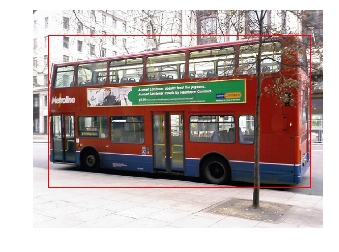

number of samples: 256, number of positive: 32, 32


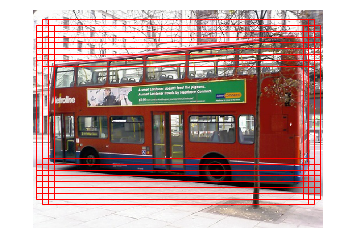

In [33]:
batch_data = db.next_batch()
db._im_list[db._data_id-1]
im = batch_data[0][0]
gt_bbox = batch_data[1][0]
draw_bounding_box(im, gt_bbox)

im_h, im_w = im.shape[0], im.shape[1]
pos_box, neg_box, pos_position, neg_position, mask, label_map, sampled_gt_bbox, t_s =\
    anchor.anchor_training_samples(im_w, im_h, gt_bbox, stride=16, 
                                   pos_thr=0.7, neg_thr=0.3, num_sample=128)
draw_bounding_box(im, pos_box)
# print(t_s)

In [6]:
im_anchor,position = anchor.gen_im_anchors(im_w, im_h, stride=16, ratios=(1, 0.5, 2), scales=(8, 16, 32))

In [7]:
valid_anchors, valid_positions =\
        anchor.remove_cross_boundary_anchors(im_w, im_h, im_anchor, position)
overlaps = bbox.bbox_overlaps(gt_bbox, valid_anchors)

[0 1 2 3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


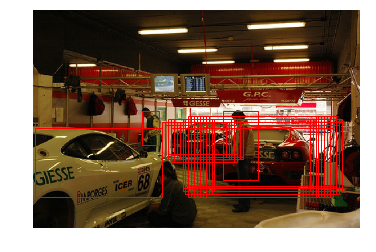

In [10]:
pos_thr = 0.7
neg_thr = 0.3

max_overlap_gt = np.max(overlaps, axis = 0)
max_overlap_gt_idx = np.argmax(overlaps, axis=0)
pos_idx = np.where(max_overlap_gt > pos_thr)
pos_gt = max_overlap_gt_idx[pos_idx]

max_overlap_anchor = np.max(overlaps, axis=1)
max_overlap_anchor_id = np.argmax(overlaps, axis=1)
gt_idx = np.array([i for i in range(len(gt_bbox))])
gt_idx = np.delete(gt_idx, np.where(max_overlap_anchor < neg_thr))
max_overlap_anchor_id = np.delete(max_overlap_anchor_id, np.where(max_overlap_anchor < neg_thr))

pos_idx = np.concatenate((max_overlap_anchor_id, pos_idx[0]))
pos_gt_idx = np.concatenate((gt_idx, pos_gt))
print((pos_gt_idx))

pos_idx, unique_idx = np.unique(pos_idx, return_index=True)
pos_gt_idx = pos_gt_idx[unique_idx]
# print(pos_idx, pos_gt_idx)
# print(len(pos_idx))

pos_box = valid_anchors[pos_idx, :]
draw_bounding_box(im, pos_box)

In [46]:
# print(pos_box)
# print(np.where(pos_gt_idx == 2))
# print(pos_box[np.where(pos_gt_idx == 2)[0], :])
# c_pos_box = pos_box[np.where(pos_gt_idx == 1)[0], :]
c_pos_box = pos_box
c_gt = gt_bbox[pos_gt_idx]
# print(pos_gt_idx)
print(c_gt)
# c_gt = np.array([c_gt])

xs, ys, ws, hs = c_gt[:, 0], c_gt[:, 1], c_gt[:, 2] - c_gt[:, 0], c_gt[:, 3] - c_gt[:, 1]
xa, ya, wa, ha = c_pos_box[:, 0], c_pos_box[:, 1], c_pos_box[:, 2] - c_pos_box[:, 0], c_pos_box[:, 3] - c_pos_box[:, 1]
tx = (xs - xa) / wa
ty = (ys - ya) / ha
tw = np.log(ws / wa)
th = np.log(hs / ha)

tt = np.vstack([tx, ty, tw, th]).transpose()
print(tt)


[[ 295.4954955   268.46846847  358.55855856  396.3963964 ]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.00900901]
 [ 378.37837838  308.10810811  562.16216216  409.0090090

In [43]:
c_pos_box = pos_box[np.where(pos_gt_idx == 2)[0], :]
c_gt = gt_bbox[2]
print(c_gt)
c_gt = np.array([c_gt])

xs, ys, ws, hs = c_gt[:, 0], c_gt[:, 1], c_gt[:, 2] - c_gt[:, 0], c_gt[:, 3] - c_gt[:, 1]
xa, ya, wa, ha = c_pos_box[:, 0], c_pos_box[:, 1], c_pos_box[:, 2] - c_pos_box[:, 0], c_pos_box[:, 3] - c_pos_box[:, 1]
tx = (xs - xa) / wa
ty = (ys - ya) / ha
tw = np.log(ws / wa)
th = np.log(hs / ha)
print(tx, ty, tw, th)

[   1.8018018   317.11711712  401.8018018   600.        ]
[-0.00626267] [-0.03603604] [ 0.13067832] [ 0.39275954]


In [40]:
neg_idx = np.where(max_overlap_gt < neg_thr)
print(len(neg_idx[0]))

n_care_idx = np.where(overlaps > neg_thr)
neg_idx = np.empty([len(valid_positions)], dtype=bool)
neg_idx.fill(True)
neg_idx[n_care_idx[1]] = False
neg_box = valid_anchors[neg_idx, :]
print(len(neg_box))

34891
34891


In [48]:
pos_idx = np.where(overlaps > 0.7)
max_idx = np.argmax(overlaps, axis=1)
max_overlap = np.max(overlaps, axis=1)  
max_idx = np.delete(max_idx, np.where(max_overlap < 0.3))
# print(pos_idx)
# print(max_idx)
# print(max_overlap)
pos_idx = np.unique(np.concatenate((max_idx, pos_idx[1])))
pos_box = valid_anchors[pos_idx, :]
pos_position = valid_positions[pos_idx, :]
# print(np.concatenate([pos_position, [np.array([i for i in range(0, len(pos_position))]).transpose()]]))
# print(pos_position)
# print(len(pos_position))
np.where(np.all(pos_position==[41, 46, 7],axis=1))
pos_idx[40]
overlaps[:, 18628]

array([ 0.        ,  0.        ,  0.        ,  0.00160663,  0.15908612,
        0.746315  ,  0.        ,  0.04574901,  0.41514775,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00221893,  0.05299796,
        0.08199744,  0.13503866,  0.00445419,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)

In [77]:
neg_idx = np.where(overlaps > 0.3)
idx = np.empty([len(valid_positions)], dtype=bool)
idx.fill(True)
# print(idx[neg_idx[1]])
idx[neg_idx[1]] = False
print(len(neg_idx[1]))
print(idx)
neg_position = valid_positions[idx, :]
print(len(neg_position))
print(len(np.where(overlaps < 0.3)[1]))

8111
[ True  True  True ...,  True  True  True]
34343
1009039


In [36]:
np.array([i for i in range(0, len(pos_position))]).transpose()
print(len(pos_position))

94


In [10]:
print(type(pos_box[0][0]))
print(type(neg_box[0][0]))
print(type(pos_position[0][0]))
print(type(neg_position[0][0]))
print(type(mask[0][0][0]))
print(type(label_map[0][0][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


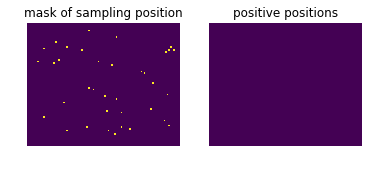

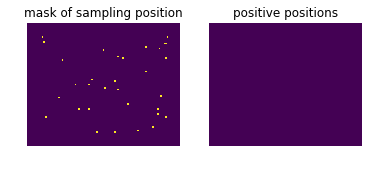

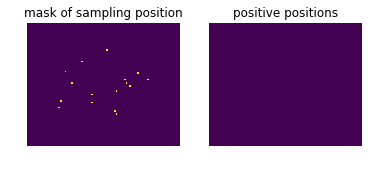

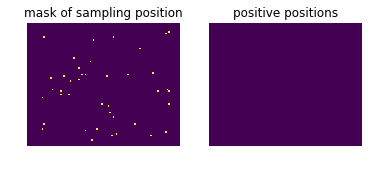

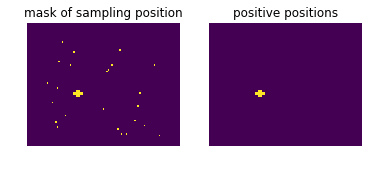

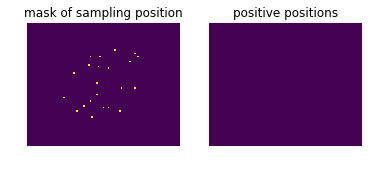

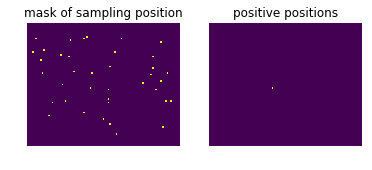

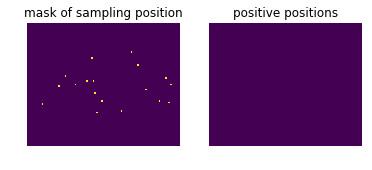

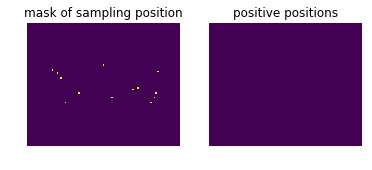

In [15]:
for k in range(0, 9):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(mask[:,:, k])
    axarr[0].set_title('mask of sampling position')
    axarr[0].axis('off')

    axarr[1].imshow(label_map[:,:,k])
    axarr[1].set_title('positive positions')
    axarr[1].axis('off')

    plt.show()